
# Cellphone Market Analytics — Portfolio Project

English-only, portfolio-oriented workflow:
- Synthetic data generation (schema-compatible)
- Product clustering (K-Means) + price statistics table (`data_grupos`)
- Correlation analysis (top-3 drivers of price)
- Multivariate linear regression (holdout test split)
- Lightweight user segmentation (K-Means)

Note: Plots are rendered as embedded images (no interactive UI assumptions).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

np.random.seed(42)
print("Initialized.")


Initialized.


Shapes: {'data': (170, 9), 'ratings': (700, 4), 'users': (240, 3)}

Data head:
 cellphone_id  price  internal memory  RAM  performance  main camera  selfie camera  battery size  weight
            1   1409              256    4        191.2            8             20          4222   198.9
            2   1293               64    6        165.9           64             16          4118   186.8
            3   1160              256    4        185.8           64             12          5050   191.6


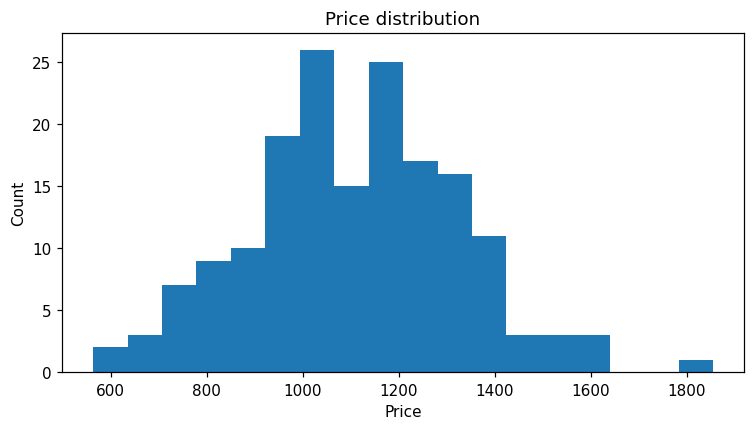

In [ ]:

def generate_synthetic_cellphone_data(seed=42):
    rng = np.random.default_rng(seed)

    n_phones = 170
    n_users = 240
    n_ratings = 700

    internal_memory = rng.choice([32, 64, 128, 256, 512], size=n_phones, p=[0.18,0.28,0.30,0.18,0.06])
    ram = rng.choice([2, 3, 4, 6, 8, 12, 16], size=n_phones, p=[0.08,0.12,0.22,0.22,0.20,0.12,0.04])
    performance = (ram*12 + np.log2(internal_memory)*18 + rng.normal(0, 12, n_phones)).clip(20, 250)
    main_camera = rng.choice([8, 12, 16, 24, 48, 64, 108], size=n_phones, p=[0.06,0.10,0.12,0.16,0.28,0.20,0.08])
    selfie_camera = rng.choice([5, 8, 12, 16, 20, 32], size=n_phones, p=[0.06,0.14,0.28,0.26,0.16,0.10])
    battery_size = rng.normal(4200, 700, n_phones).round().astype(int).clip(2200, 6500)
    weight = (rng.normal(185, 18, n_phones) + (battery_size-4200)/200).round(1)

    price = (
        60
        + 0.55*internal_memory
        + 22*ram
        + 1.4*performance
        + 1.6*main_camera
        + 0.9*selfie_camera
        + 0.04*battery_size
        + 1.8*weight
        + rng.normal(0, 120, n_phones)
    )
    price = np.maximum(79, price).round(0).astype(int)

    data = pd.DataFrame({
        "cellphone_id": np.arange(1, n_phones+1),
        "price": price,
        "internal memory": internal_memory.astype(int),
        "RAM": ram.astype(int),
        "performance": performance.round(1),
        "main camera": main_camera.astype(int),
        "selfie camera": selfie_camera.astype(int),
        "battery size": battery_size.astype(int),
        "weight": weight,
    })

    users = pd.DataFrame({
        "user_id": np.arange(1, n_users+1),
        "age": rng.integers(16, 66, size=n_users),
        "gender": rng.choice(["F", "M"], size=n_users, p=[0.48, 0.52]),
    })

    phone_quality = (
        0.0025*data["performance"].to_numpy()
        + 0.0018*data["main camera"].to_numpy()
        + 0.0009*data["battery size"].to_numpy()
        - 0.0009*data["weight"].to_numpy()
    )
    phone_quality = (phone_quality - phone_quality.min()) / (phone_quality.max() - phone_quality.min() + 1e-9)

    phone_popularity = (rng.random(n_phones)*0.6 + phone_quality*0.4)
    phone_ids = rng.choice(data["cellphone_id"], size=n_ratings, replace=True, p=phone_popularity/phone_popularity.sum())
    user_ids = rng.integers(1, n_users+1, size=n_ratings)

    user_strictness = rng.normal(0, 0.25, n_users)
    base_rating = 2.4 + 2.2*phone_quality[(phone_ids-1)]
    noise = rng.normal(0, 0.65, n_ratings)
    strict = user_strictness[(user_ids-1)]
    rating = np.clip(base_rating - strict + noise, 1.0, 5.0)

    ratings = pd.DataFrame({
        "rating_id": np.arange(1, n_ratings+1),
        "cellphone_id": phone_ids,
        "user_id": user_ids,
        "rating": rating.round(1),
    })

    return data, ratings, users

data, ratings, users = generate_synthetic_cellphone_data(seed=42)

print("Shapes:", {"data": data.shape, "ratings": ratings.shape, "users": users.shape})
print("\nData head:")
print(data.head(3).to_string(index=False))

# Plot: price distribution
plt.figure(figsize=(8,4))
plt.hist(data["price"], bins=18)
plt.title("Price distribution")
plt.xlabel("Price")
plt.ylabel("Count")


data_grupos:
 Grupo k means  Precio promedio  Desv est precio  Precio mínimo  Precio máximo
             0      1006.424242       192.921990            563           1409
             1      1295.096154       178.939387            951           1855
             2      1061.519231       163.856883            743           1451


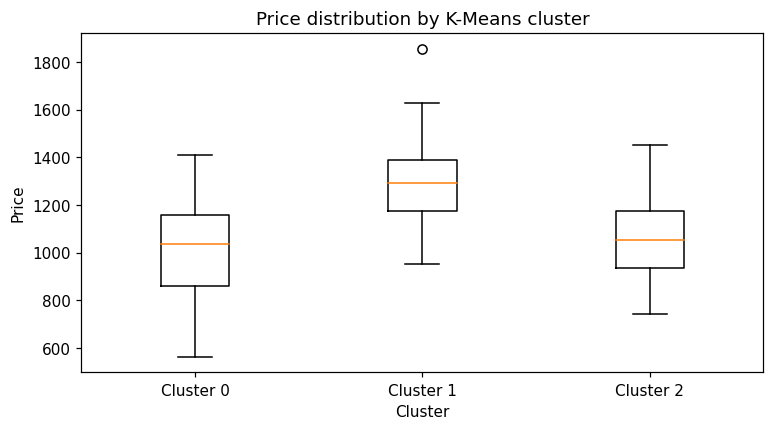

In [ ]:

# K-Means clustering (3 clusters) on specs and price summary table
features = ["internal memory","RAM","performance","main camera","selfie camera","battery size"]
data2 = data[["price"] + features].dropna().copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data2[features])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=5, max_iter=150)
data2["cluster"] = kmeans.fit_predict(X_scaled)

data_grupos = data2.groupby("cluster").agg(
    **{
        "Precio promedio": ("price", "mean"),
        "Desv est precio": ("price", "std"),
        "Precio mínimo": ("price", "min"),
        "Precio máximo": ("price", "max")
    }
).reset_index().rename(columns={"cluster":"Grupo k means"})

data_grupos = data_grupos[["Grupo k means","Precio promedio","Desv est precio","Precio mínimo","Precio máximo"]]
print("data_grupos:")
print(data_grupos.to_string(index=False))

# Plot: boxplot by cluster
plt.figure(figsize=(8,4))
plt.boxplot([data2.loc[data2["cluster"]==k, "price"] for k in sorted(data2["cluster"].unique())],
            labels=[f"Cluster {k}" for k in sorted(data2["cluster"].unique())])
plt.title("Price distribution by K-Means cluster")
plt.xlabel("Cluster")
plt.ylabel("Price")


Top-3 correlated with price:
variable_1 = performance
variable_2 = RAM
variable_3 = internal memory


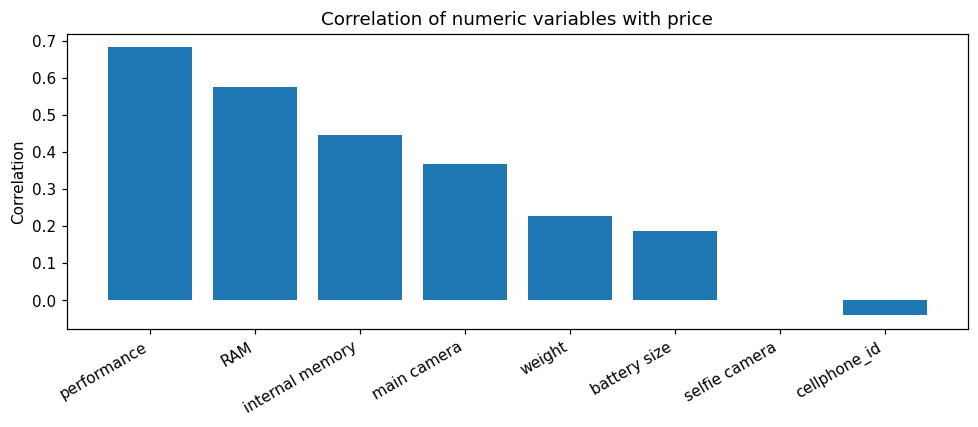

In [ ]:

# Correlation (top 3)
quant = data.select_dtypes(include=["number"]).copy()
corr_with_price = quant.corr()["price"].sort_values(ascending=False)

top3 = corr_with_price.drop(index=["price"]).head(3)
variable_1, variable_2, variable_3 = top3.index.tolist()

print("Top-3 correlated with price:")
print("variable_1 =", variable_1)
print("variable_2 =", variable_2)
print("variable_3 =", variable_3)

plt.figure(figsize=(9,4))
vals = corr_with_price.drop(index=["price"]).values
labs = corr_with_price.drop(index=["price"]).index.tolist()
plt.bar(range(len(vals)), vals)
plt.title("Correlation of numeric variables with price")
plt.xticks(range(len(vals)), labs, rotation=30, ha="right")
plt.ylabel("Correlation")
plt.tight_layout()


coeficientes = [ 1.07937272 28.33497635  0.71220113]
intercepto = 633.8268259815709
r2_score_final = 0.47938849079991763


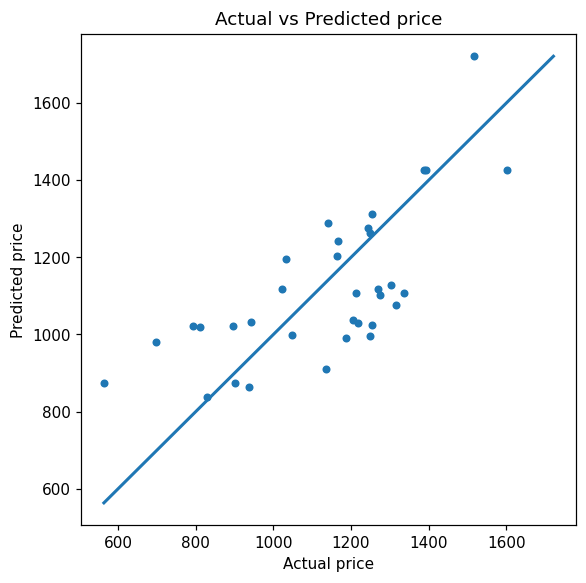

In [ ]:

# Multivariate regression
X = data[[variable_1, variable_2, variable_3]].copy()
y = data["price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

coeficientes = modelo.coef_
intercepto = float(modelo.intercept_)
y_pred = modelo.predict(X_test)
r2_score_final = float(r2_score(y_test, y_pred))

print("coeficientes =", coeficientes)
print("intercepto =", intercepto)
print("r2_score_final =", r2_score_final)

plt.figure(figsize=(5.8,5.8))
plt.scatter(y_test, y_pred, s=18)
mn = min(float(y_test.min()), float(y_pred.min()))
mx = max(float(y_test.max()), float(y_pred.max()))
plt.plot([mn, mx], [mn, mx], linewidth=2)
plt.title("Actual vs Predicted price")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")


In [ ]:

# Lightweight user segmentation (K-Means) on avg rating + demographics
avg_rating = ratings.groupby("user_id")["rating"].mean().rename("rating_avg")
data_u = users.merge(avg_rating, on="user_id", how="left").dropna().copy()

le = LabelEncoder()
data_u["gender_num"] = le.fit_transform(data_u["gender"])

X_u = data_u[["rating_avg","age","gender_num"]].astype(float).copy()
scaler_u = MinMaxScaler()
X_u[:] = scaler_u.fit_transform(X_u)

clusters = 4  # portfolio choice (interpretable segmentation)
kmeans_u = KMeans(n_clusters=clusters, random_state=42, n_init=10, max_iter=200).fit(X_u)
data_u["cluster"] = kmeans_u.predict(X_u)

profile = data_u.groupby("cluster").agg(
    users=("user_id","count"),
    avg_rating=("rating_avg","mean"),
    avg_age=("age","mean"),
    pct_male=("gender", lambda s: float((s=="M").mean()))
).reset_index()

print("User cluster profiles:")
print(profile.to_string(index=False))


User cluster profiles:
 cluster  users  avg_rating   avg_age  pct_male
       0     57    3.456149 27.473684       1.0
       1     60    3.449480 29.350000       0.0
       2     61    3.458443 53.508197       1.0
       3     51    3.486008 54.901961       0.0


In [ ]:

# Export artifacts
from pathlib import Path
out_dir = Path("cellphone_portfolio_outputs")
out_dir.mkdir(exist_ok=True)

data_grupos.to_csv(out_dir / "kmeans_phone_price_summary.csv", index=False)
corr_with_price.to_csv(out_dir / "correlation_with_price.csv")
profile.to_csv(out_dir / "user_cluster_profiles.csv", index=False)

print("Saved artifacts in:", out_dir.resolve())
for p in sorted(out_dir.glob("*")):
    print(" -", p.name)


Saved artifacts in: /home/oai/cellphone_portfolio_outputs
 - correlation_with_price.csv
 - kmeans_phone_price_summary.csv
 - user_cluster_profiles.csv
